# Статистика по продуктам

In [1]:
import matplotlib.pyplot as plt
import psycopg2 as psy
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot, plot


def state_flag(row):
    if row['shipped_date'] == None:
        return 1
    else:
        return 0

def sql_to_pd(query, insert_state_flag=False):
    '''
    Функция стучится в базу данных и обрабатывает указанный в аргументе запрос.
    Затем преобразует полученные данные в датафрейм и возвращает его.

    query - SQL запрос в базу данных, которые указанны в функции.
    
    insert_state_flag - подходит исключительно для БД из задания.
                        Если активен, добавляет столбец со статусом
                        заказа в датафрейм используя функцию state_flag()
                        (0-неактивный, 1-активный)
    '''
    try:
        # Connect to an existing database
        connection = psy.connect(user="postgres",
                                  password="",
                                  host="127.0.0.1",
                                  port="5432",
                                  database="postgres")
        # Create a cursor to perform database operations
        cursor = connection.cursor()
        cursor.execute(query)
        colnames = [desc[0] for desc in cursor.description]
        record = cursor.fetchall()
        # Create a dataframe with the data from a database
        data_frame = pd.DataFrame(record, columns=colnames)
        # Использую функцию выше в случае если нужно поставить флаг статуса заказа, включен по умолчанию
        if insert_state_flag:
            data_frame['order_state'] = data_frame.apply(state_flag, axis=1)
        return data_frame
    except Exception as e:
        print("Error while connecting to PostgreSQL", e)
    finally:
        if (connection):
            cursor.close()
            connection.close()

## 1. Выведите клиента с наибольшим количеством активных заказов

In [2]:
df = sql_to_pd('SELECT * FROM orders\
                    INNER JOIN order_details USING(order_id)\
                    INNER JOIN customers USING(customer_id)'
               , insert_state_flag=True
              )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       2155 non-null   object 
 1   order_id          2155 non-null   int64  
 2   employee_id       2155 non-null   int64  
 3   order_date        2155 non-null   object 
 4   required_date     2155 non-null   object 
 5   shipped_date      2082 non-null   object 
 6   ship_via          2155 non-null   int64  
 7   freight           2155 non-null   float64
 8   ship_name         2155 non-null   object 
 9   ship_address      2155 non-null   object 
 10  ship_city         2155 non-null   object 
 11  ship_region       856 non-null    object 
 12  ship_postal_code  2100 non-null   object 
 13  ship_country      2155 non-null   object 
 14  product_id        2155 non-null   int64  
 15  unit_price        2155 non-null   float64
 16  quantity          2155 non-null   int64  


In [3]:
highest_active = df\
                .groupby('customer_id')\
                .agg({'company_name': 'first', 'contact_name': 'first', 'address': 'first', 'order_state':'sum'})\
                .sort_values(by='order_state', ascending=False)\
                .reset_index()
highest_active.rename(columns={'order_state': 'active_orders_count'}, inplace=True)
highest_active.head(1)

customer_id                company_name  contact_name          address  \
0       RATTC  Rattlesnake Canyon Grocery  Paula Wilson  2817 Milton Dr.   

   active_orders_count  
0                   25

## 2. Выведите клиентов по количеству активных и неактивных заказов

In [4]:
# неактивные заказы
non_active_orders = df[df['order_state'] == 0][['customer_id','company_name', 'contact_name', 'address', 'order_state']]
non_active_orders = non_active_orders\
                    .groupby('customer_id')\
                    .agg({'company_name': 'first', 'contact_name': 'first', 'address': 'first', 'order_state':'count'})\
                    .reset_index()
non_active_orders.rename(columns={'order_state': 'non_active_count'}, inplace=True)

# активные заказы
active_orders = df[df['order_state'] > 0][['customer_id','company_name', 'contact_name', 'address', 'order_state']]
active_orders = active_orders\
                    .groupby('customer_id')\
                    .agg({'company_name': 'first', 'contact_name': 'first', 'address': 'first', 'order_state':'count'})\
                    .reset_index()
active_orders.rename(columns={'order_state': 'active_count'}, inplace=True)

non_active_orders.merge(active_orders, how='left').fillna(0)

# список всех клиентов и количесво актиных и неактивных заказов

customer_id                        company_name             contact_name  \
0        ALFKI                 Alfreds Futterkiste             Maria Anders   
1        ANATR  Ana Trujillo Emparedados y helados             Ana Trujillo   
2        ANTON             Antonio Moreno Taquería           Antonio Moreno   
3        AROUT                     Around the Horn             Thomas Hardy   
4        BERGS                  Berglunds snabbköp       Christina Berglund   
..         ...                                 ...                      ...   
84       WARTH                      Wartian Herkku         Pirkko Koskitalo   
85       WELLI              Wellington Importadora            Paula Parente   
86       WHITC                White Clover Markets           Karl Jablonski   
87       WILMK                         Wilman Kala          Matti Karttunen   
88       WOLZA                      Wolski  Zajazd  Zbyszek Piestrzeniewicz   

                          address  non_active_count  active_count  
0                   Obere Str. 57                12           0.0  
1   Avda. de la Constitución 2222                10           0.0  
2                 Mataderos  2312                17           0.0  
3                 120 Hanover Sq.                30           0.0  
4                 Berguvsvägen  8                52           0.0  
..                            ...               ...           ...  
84                    Torikatu 38                37           0.0  
85             Rua do Mercado, 12                19           0.0  
86    305 - 14th Ave. S. Suite 3B                40           0.0  
87                  Keskuskatu 45                17           0.0  
88                ul. Filtrowa 68                16           0.0  

[89 rows x 6 columns]

In [5]:
# однако будет более информативным ваиратнт где мы выберем только тех клиентов которые имеют как активные так и неактивные заказы
clients = non_active_orders.merge(active_orders, how='left').fillna(0)
clients = clients[(clients['active_count'] != 0) & (clients['non_active_count'] != 0)]
clients['active_count'] = clients['active_count'].astype(int)
clients['total_orders'] = clients['active_count'] + clients['non_active_count'] # получаем также сумму активныйх и неактивных заказов
clients = clients.sort_values(by='total_orders', ascending=False)\
                 .reset_index() # сортирую таблицу по общему количеству заказов
clients

index customer_id                company_name         contact_name  \
0      19       ERNSH                Ernst Handel        Roland Mendel   
1      62       RATTC  Rattlesnake Canyon Grocery         Paula Wilson   
2       8       BONAP                    Bon app'     Laurence Lebihan   
3      59       QUEEN               Queen Cozinha       Lúcia Carvalho   
4      42       LEHMS         Lehmanns Marktstand       Renate Messner   
5      45       LINOD            LINO-Delicateses     Felipe Izquierdo   
6       9       BOTTM       Bottom-Dollar Markets    Elizabeth Lincoln   
7      44       LILAS           LILA-Supermercado      Carlos González   
8      39       LAMAI            La maison d'Asie       Annette Roulet   
9      65       RICSU          Richter Supermarkt         Michael Holz   
10     64       RICAR          Ricardo Adocicados       Janete Limeira   
11     30       GREAL     Great Lakes Food Market        Howard Snyder   
12     63       REGGC          Reggiani Caseifici      Maurizio Moroni   
13     70       SIMOB               Simons bistro       Jytte Petersen   
14     55       PERIC   Pericles Comidas clásicas  Guillermo Fernández   
15      5       BLAUS     Blauer See Delikatessen           Hanna Moos   
16     61       RANCH               Rancho grande     Sergio Gutiérrez   
17     11       CACTU  Cactus Comidas para llevar     Patricio Simpson   

                                           address  non_active_count  \
0                                     Kirchgasse 6                95   
1                                  2817 Milton Dr.                46   
2                             12, rue des Bouchers                41   
3                        Alameda dos Canàrios, 891                37   
4                                     Magazinweg 7                35   
5                          Ave. 5 de Mayo Porlamar                31   
6                               23 Tsawassen Blvd.                33   
7   Carrera 52 con Ave. Bolívar #65-98 Llano Largo                30   
8                            1 rue Alsace-Lorraine                30   
9                                Grenzacherweg 237                27   
10                             Av. Copacabana, 267                24   
11                                2732 Baker Blvd.                20   
12                          Strada Provinciale 124                20   
13                                    Vinbæltet 34                14   
14                        Calle Dr. Jorge Cash 321                12   
15                                  Forsterstr. 57                11   
16                          Av. del Libertador 900                10   
17                                     Cerrito 333                 9   

    active_count  total_orders  
0              7           102  
1             25            71  
2              3            44  
3              3            40  
4              4            39  
5              4            35  
6              2            35  
7              4            34  
8              1            31  
9              3            30  
10             3            27  
11             2            22  
12             2            22  
13             1            15  
14             2            14  
15             3            14  
16             2            12  
17             2            11

## 3. Нарисуйте круговую диаграмму по топ 10 самых больших по заказам клиентов, разделенных на активные и неактивные заказы

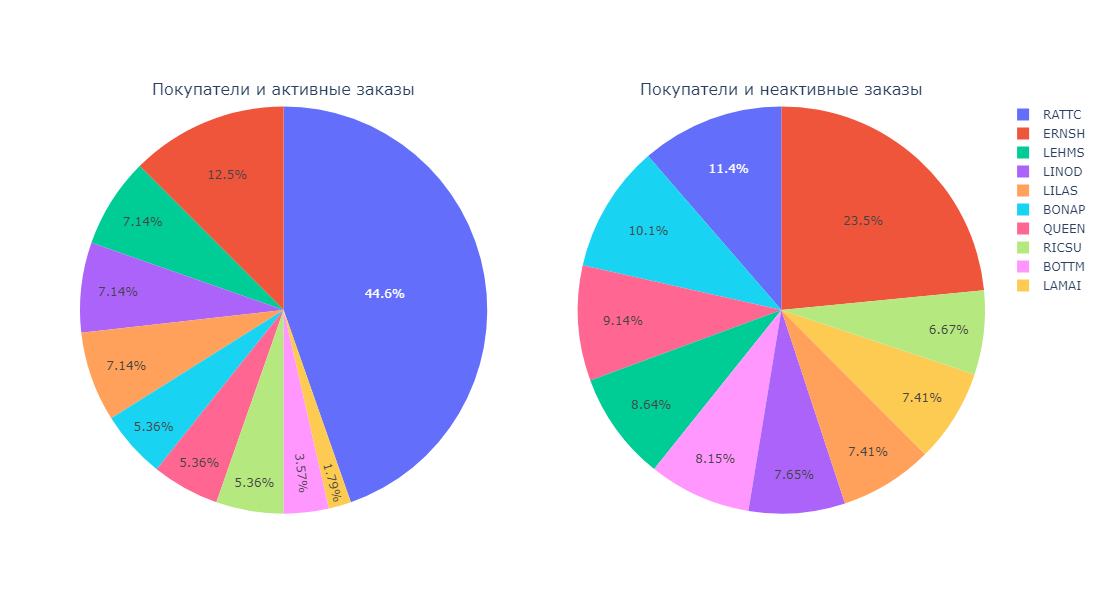

In [6]:
clients_top10 = clients.head(10)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]], subplot_titles = ('Покупатели и активные заказы'\
                                                                                                  , 'Покупатели и неактивные заказы'))

fig.add_trace(go.Pie(
values = clients_top10['active_count'],
labels = clients_top10['customer_id'],
domain = dict(x=[0, 0.5]),
name = 'Покупатели и активные заказы'),
row = 1, col = 1)

fig.add_trace(go.Pie(
values = clients_top10['non_active_count'],
labels = clients_top10['customer_id'],
domain = dict(x=[0.5, 1.0]),
name = 'Покупатели и неактивные заказы'),
row = 1, col = 2)

fig.update_layout(width=1000, height=600) 

iplot(fig)



## 4. Выведите продукт с наибольшим количеством активных заказов

In [7]:
# проверяю наименование таблиц, спасибо Chat-GPT
sql_to_pd("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'")

table_name
0    customer_demographics
1   customer_customer_demo
2                customers
3                employees
4               categories
5                 products
6                suppliers
7                   orders
8                 shippers
9                   region
10             territories
11    employee_territories
12           order_details
13               us_states

In [8]:
products = sql_to_pd("SELECT * FROM products")
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         77 non-null     int64  
 1   product_name       77 non-null     object 
 2   supplier_id        77 non-null     int64  
 3   category_id        77 non-null     int64  
 4   quantity_per_unit  77 non-null     object 
 5   unit_price         77 non-null     float64
 6   units_in_stock     77 non-null     int64  
 7   units_on_order     77 non-null     int64  
 8   reorder_level      77 non-null     int64  
 9   discontinued       77 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       2155 non-null   object 
 1   order_id          2155 non-null   int64  
 2   employee_id       2155 non-null   int64  
 3   order_date        2155 non-null   object 
 4   required_date     2155 non-null   object 
 5   shipped_date      2082 non-null   object 
 6   ship_via          2155 non-null   int64  
 7   freight           2155 non-null   float64
 8   ship_name         2155 non-null   object 
 9   ship_address      2155 non-null   object 
 10  ship_city         2155 non-null   object 
 11  ship_region       856 non-null    object 
 12  ship_postal_code  2100 non-null   object 
 13  ship_country      2155 non-null   object 
 14  product_id        2155 non-null   int64  
 15  unit_price        2155 non-null   float64
 16  quantity          2155 non-null   int64  


In [10]:
# дополняю основной датасет
df = df.merge(products, on='product_id', how='left')

# выбираю только несколько, на мой взгляд, полезных столбцов
clients_and_products = df[['customer_id', 'order_id', 'product_id', 'product_name', 'order_state']]

# вывожу только те строки которые имеют статус заказа 1
active_products = clients_and_products[clients_and_products['order_state'] > 0]

In [11]:
# посчитаю кол-во активных заказов на каждый продукт
output = active_products.groupby('product_id')\
                        .agg({'product_name': 'first', 'order_state': 'count'})\
                        .sort_values(by='order_state', ascending=False)\
                        .reset_index()

output.rename(columns={'order_state': 'sum'}, inplace=True)
output[output['sum'] == output['sum'].max()]

# в данном случае два продукта имеют максимальное кол-во заказов, поэтому я вывел оба.

product_id       product_name  sum
0           2              Chang    4
1          60  Camembert Pierrot    4

## 5. Выведите количества продуктов разделенные по активности

In [12]:
quantity_by_activity = df[['order_id', 'product_id', 'product_name', 'quantity', 'order_state']].copy()
quantity_by_activity['order_state'] = quantity_by_activity['order_state']

quantity_by_activity = quantity_by_activity.groupby(['product_id', 'product_name', 'order_state']).agg({'quantity': 'sum'}).reset_index()
quantity_by_activity

# получается такая картина, так как каждый продукт может иметь определенное количество как активных так и неактивных заказов.

product_id                     product_name  order_state  quantity
0             1                             Chai            0       788
1             1                             Chai            1        40
2             2                            Chang            0       995
3             2                            Chang            1        62
4             3                    Aniseed Syrup            0       324
..          ...                              ...          ...       ...
121          75             Rhönbräu Klosterbier            1         4
122          76                     Lakkalikööri            0       979
123          76                     Lakkalikööri            1         2
124          77  Original Frankfurter grüne Soße            0       761
125          77  Original Frankfurter grüne Soße            1        30

[126 rows x 4 columns]

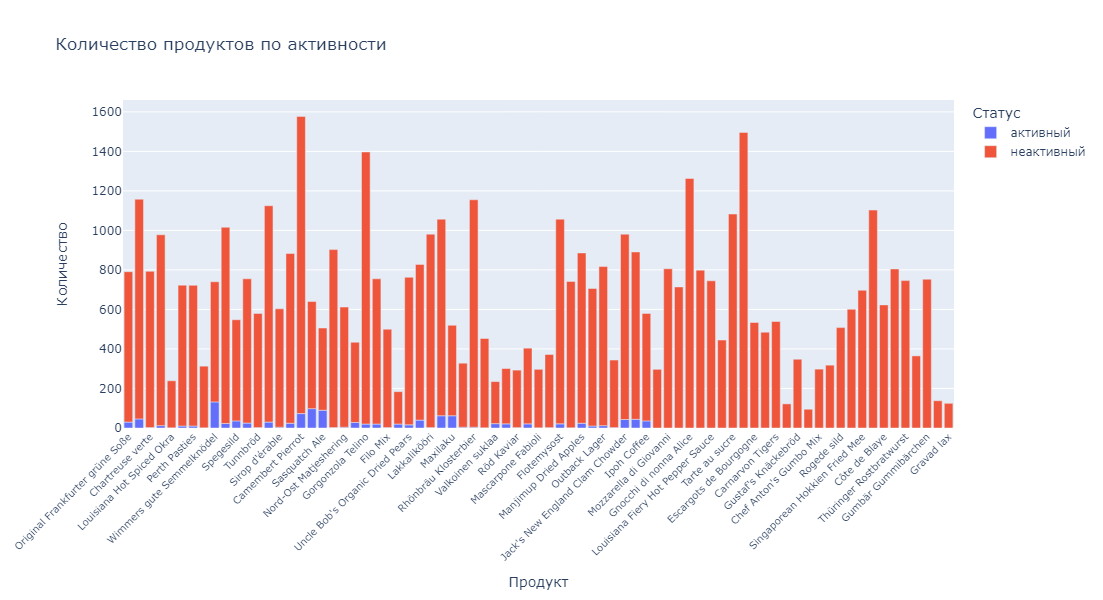

In [13]:
# визуализация
vis_quantity_by_activity = quantity_by_activity[['product_name', 'order_state', 'quantity']].copy()
vis_quantity_by_activity['order_state'] = vis_quantity_by_activity['order_state'].replace({0: 'неактивный', 1: 'активный'})
vis_quantity_by_activity.sort_values(by='order_state', inplace=True)
vis_quantity_by_activity.columns = ['Продукт', 'Статус', 'Количество']

fig = px.bar(vis_quantity_by_activity, x='Продукт', y='Количество', color='Статус', title="Количество продуктов по активности")

fig.update_xaxes(tickangle=-45, tickfont=dict(size=10))
fig.update_layout(width=1000, height=600)

iplot(fig)

## 6. Нарисуйте диаграмму по топ 10 самым продаваемым продуктам

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        2155 non-null   object 
 1   order_id           2155 non-null   int64  
 2   employee_id        2155 non-null   int64  
 3   order_date         2155 non-null   object 
 4   required_date      2155 non-null   object 
 5   shipped_date       2082 non-null   object 
 6   ship_via           2155 non-null   int64  
 7   freight            2155 non-null   float64
 8   ship_name          2155 non-null   object 
 9   ship_address       2155 non-null   object 
 10  ship_city          2155 non-null   object 
 11  ship_region        856 non-null    object 
 12  ship_postal_code   2100 non-null   object 
 13  ship_country       2155 non-null   object 
 14  product_id         2155 non-null   int64  
 15  unit_price_x       2155 non-null   float64
 16  quantity           2155 

In [15]:
# Как я понял, самый продаваемый товар - это тот который имеет самое большее количество заказов (активные + неактивные)
top_10_products = df.groupby(['product_name']).agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).reset_index()
top_10_products = top_10_products.head(10)
top_10_products

product_name  quantity
0       Camembert Pierrot      1577
1    Raclette Courdavault      1496
2       Gorgonzola Telino      1397
3  Gnocchi di nonna Alice      1263
4                 Pavlova      1158
5    Rhönbräu Klosterbier      1155
6      Guaraná Fantástica      1125
7        Boston Crab Meat      1103
8          Tarte au sucre      1083
9                   Chang      1057

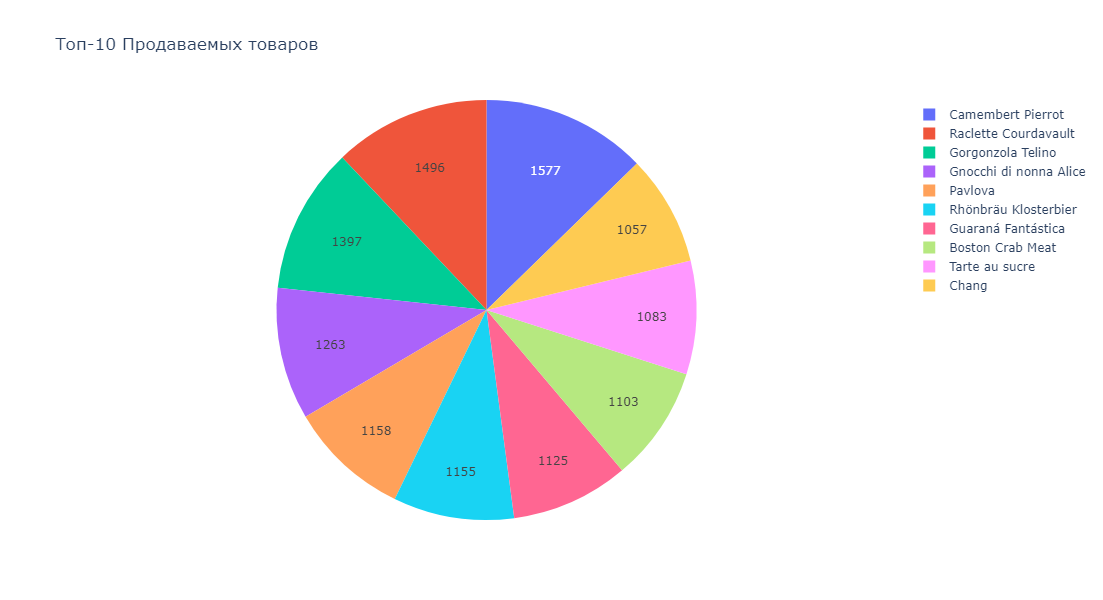

In [16]:
# Пай-чарт
fig = px.pie(top_10_products, values='quantity', names='product_name', title='Топ-10 Продаваемых товаров')
fig.update_traces(hoverinfo='label+percent+value', textinfo='value') # благодаря этой строке отображаются реальные значения вместо процентов.

fig.update_layout(width=800, height=600)
fig.show()

## 7. Добавьте в вашу таблицу должность и имя сотрудника, а также его город, гдеон работает

In [17]:
# сперва получим необходимые данные из БД
employees = sql_to_pd('SELECT * FROM employees')[['employee_id', 'first_name', 'title', 'city']]
employees.rename(columns={'title': 'job_title', 'city': 'empl_city'}, inplace=True)

# Теперь можно сделать слияние
df = df.merge(employees, on='employee_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        2155 non-null   object 
 1   order_id           2155 non-null   int64  
 2   employee_id        2155 non-null   int64  
 3   order_date         2155 non-null   object 
 4   required_date      2155 non-null   object 
 5   shipped_date       2082 non-null   object 
 6   ship_via           2155 non-null   int64  
 7   freight            2155 non-null   float64
 8   ship_name          2155 non-null   object 
 9   ship_address       2155 non-null   object 
 10  ship_city          2155 non-null   object 
 11  ship_region        856 non-null    object 
 12  ship_postal_code   2100 non-null   object 
 13  ship_country       2155 non-null   object 
 14  product_id         2155 non-null   int64  
 15  unit_price_x       2155 non-null   float64
 16  quantity           2155 

In [18]:
df

customer_id  order_id  employee_id  order_date required_date  \
0          VINET     10248            5  1996-07-04    1996-08-01   
1          VINET     10248            5  1996-07-04    1996-08-01   
2          VINET     10248            5  1996-07-04    1996-08-01   
3          TOMSP     10249            6  1996-07-05    1996-08-16   
4          TOMSP     10249            6  1996-07-05    1996-08-16   
...          ...       ...          ...         ...           ...   
2150       RATTC     11077            1  1998-05-06    1998-06-03   
2151       RATTC     11077            1  1998-05-06    1998-06-03   
2152       RATTC     11077            1  1998-05-06    1998-06-03   
2153       RATTC     11077            1  1998-05-06    1998-06-03   
2154       RATTC     11077            1  1998-05-06    1998-06-03   

     shipped_date  ship_via  freight                   ship_name  \
0      1996-07-16         3    32.38   Vins et alcools Chevalier   
1      1996-07-16         3    32.38   Vins et alcools Chevalier   
2      1996-07-16         3    32.38   Vins et alcools Chevalier   
3      1996-07-10         1    11.61          Toms Spezialitäten   
4      1996-07-10         1    11.61          Toms Spezialitäten   
...           ...       ...      ...                         ...   
2150         None         2     8.53  Rattlesnake Canyon Grocery   
2151         None         2     8.53  Rattlesnake Canyon Grocery   
2152         None         2     8.53  Rattlesnake Canyon Grocery   
2153         None         2     8.53  Rattlesnake Canyon Grocery   
2154         None         2     8.53  Rattlesnake Canyon Grocery   

            ship_address  ... category_id   quantity_per_unit unit_price_y  \
0     59 rue de l'Abbaye  ...           4           1 kg pkg.        21.00   
1     59 rue de l'Abbaye  ...           5     32 - 1 kg pkgs.        14.00   
2     59 rue de l'Abbaye  ...           4    24 - 200 g pkgs.        34.80   
3          Luisenstr. 48  ...           7    40 - 100 g pkgs.        23.25   
4          Luisenstr. 48  ...           7    50 - 300 g pkgs.        53.00   
...                  ...  ...         ...                 ...          ...   
2150     2817 Milton Dr.  ...           5  20 bags x 4 pieces        33.25   
2151     2817 Milton Dr.  ...           2      24 - 8 oz jars        17.00   
2152     2817 Milton Dr.  ...           8     24 - 150 g jars        15.00   
2153     2817 Milton Dr.  ...           1  24 - 0.5 l bottles         7.75   
2154     2817 Milton Dr.  ...           2            12 boxes        13.00   

     units_in_stock  units_on_order  reorder_level  discontinued  first_name  \
0                22              30             30             0      Steven   
1                26               0              0             1      Steven   
2                14               0              0             0      Steven   
3                35               0              0             0     Michael   
4                20               0             10             0     Michael   
...             ...             ...            ...           ...         ...   
2150             22              80             30             0       Nancy   
2151              4             100             20             0       Nancy   
2152            101               0              5             0       Nancy   
2153            125               0             25             0       Nancy   
2154             32               0             15             0       Nancy   

                 job_title empl_city  
0            Sales Manager    London  
1            Sales Manager    London  
2            Sales Manager    London  
3     Sales Representative    London  
4     Sales Representative    London  
...                    ...       ...  
2150  Sales Representative   Seattle  
2151  Sales Representative   Seattle  
2152  Sales Representative   Seattle  
2153  Sales Representative   Seattle  
2154  Sales Representative   Sea

## 8. Теперь выведите количество активных и неактивных заказов по сотрудникам

In [20]:
# неактивные заказы
non_active_orders_employees = df[df['order_state'] == 0][['employee_id', 'first_name', 'job_title', 'empl_city', 'order_state']]
non_active_orders_employees = non_active_orders_employees\
                    .groupby(['employee_id', 'first_name', 'job_title', 'empl_city'])\
                    .agg({'order_state':'count'})\
                    .reset_index()
non_active_orders_employees.rename(columns={'order_state': 'non_active_count'}, inplace=True)

# активные заказы
active_orders_employees = df[df['order_state'] > 0][['employee_id', 'first_name', 'job_title', 'empl_city', 'order_state']]
active_orders_employees = active_orders_employees\
                    .groupby(['employee_id', 'first_name', 'job_title', 'empl_city'])\
                    .agg({'order_state':'count'})\
                    .reset_index()
active_orders_employees.rename(columns={'order_state': 'active_count'}, inplace=True)

non_active_orders_employees.merge(active_orders_employees, how='left').fillna(0)

employee_id first_name                 job_title empl_city  \
0            1      Nancy      Sales Representative   Seattle   
1            2     Andrew     Vice President, Sales    Tacoma   
2            3      Janet      Sales Representative  Kirkland   
3            4   Margaret      Sales Representative   Redmond   
4            5     Steven             Sales Manager    London   
5            6    Michael      Sales Representative    London   
6            7     Robert      Sales Representative    London   
7            8      Laura  Inside Sales Coordinator   Seattle   
8            9       Anne      Sales Representative    London   

   non_active_count  active_count  
0               314          31.0  
1               232           9.0  
2               321           0.0  
3               409          11.0  
4               117           0.0  
5               164           4.0  
6               171           5.0  
7               250          10.0  
8               104           3.0

In [27]:
# тут я скопировал код из предшествующего задания
# вывожу работников которые имеют и активные и неактивные заказы записанные на них

employees_orders = non_active_orders_employees.merge(active_orders_employees, how='left').fillna(0)
employees_orders = employees_orders[(employees_orders['active_count'] != 0) & (employees_orders['non_active_count'] != 0)]
employees_orders['active_count'] = employees_orders['active_count'].astype(int)
employees_orders['total_orders'] = employees_orders['active_count'] + employees_orders['non_active_count'] # получаем также сумму активныйх и неактивных заказов
employees_orders = employees_orders.sort_values(by='total_orders', ascending=False)\
                 .reset_index() # сортирую таблицу по общему количеству заказов
employees_orders

index  employee_id first_name                 job_title empl_city  \
0      3            4   Margaret      Sales Representative   Redmond   
1      0            1      Nancy      Sales Representative   Seattle   
2      7            8      Laura  Inside Sales Coordinator   Seattle   
3      1            2     Andrew     Vice President, Sales    Tacoma   
4      6            7     Robert      Sales Representative    London   
5      5            6    Michael      Sales Representative    London   
6      8            9       Anne      Sales Representative    London   

   non_active_count  active_count  total_orders  
0               409            11           420  
1               314            31           345  
2               250            10           260  
3               232             9           241  
4               171             5           176  
5               164             4           168  
6               104             3           107

## 9. Выгрузите таблицу с заказами и сотрудниками в эксель. (Метод to_excel)

In [28]:
# openpyxl должен быть установлен
employees_orders.to_excel('Employees_and_orderds.xlsx')